## Richards Equation Toy model -- Trying the Julia Solvers

In [1]:
using DiffEqOperators,  DifferentialEquations,  Plots
using Parameters
using Revise
#from jupyterthemes import jtplot
#jtplot.style(theme=’monokai’, context=’notebook’, ticks=True, grid=False)

In [2]:
FT = Float64

include("Water/water_functions.jl")
include("Water/hydraulic_conductivity_composable.jl")
include("Water/matric_potential_composable.jl")

matric_potential

In [3]:
hydraulic_model = Havercamp{FT}();
matric_model    = vanGenuchten{FT}();

In [4]:
K_sat  = 0.0443 / (3600*100)
porosity = 0.495 # Read in from data base
S_s = 10e-4  # [ m-1] ## Check this value !!

#IC/BC values  - to be specified/calculated via a BC/IC struct, and treated as an attribute of the model.
ν_0 = 0.24
ν_surface = porosity#+1e-5#-1e-3
S_l_0 = effective_saturation(porosity, ν_0)
ψ_0 = pressure_head(matric_model,S_l_0,porosity,S_s,ν_0)
println(ψ_0)
κ_0 = hydraulic_conductivity(hydraulic_model, K_sat, S_l_0, ψ_0,0.0)

-1.938733644779751


1.3548894996468134e-9

In [17]:
L  = 1.0 # depth in meters
nknots = 99 #99
dz = -L/(nknots+1)#1000.0/(nknots+1)
knots = range(dz, step=dz, length=nknots)

z = collect(knots)
S = zeros(length(z))
#S[60]=-0.00002;#0.00001
ord_deriv = 2
ord_approx = 2

2

In [6]:
const Δ = CenteredDifference(ord_deriv, ord_approx, dz, nknots)
const ∇ = CenteredDifference(1, ord_approx, dz, nknots)
bc = DirichletBC(ν_surface, ν_0)


RobinBC{Float64,Array{Float64,1}}([-0.0, 0.0], 0.495, [-0.0, 0.0], 0.24)

In [7]:
bc1 = RobinBC((1., 0., ν_surface), (0., 1., 0.), dz, 1) 

RobinBC{Float64,Array{Float64,1}}([0.0], 0.495, [1.0], -0.0)

In [14]:
function soil_water(ν,p,t; bc=bc, porosity=porosity,S=S, S_s=S_s, HM=hydraulic_model, MM=matric_model, K_sat=K_sat, z=z )
    #bcFlux = DirichletBC(0, 0)
    # Apply BC to moisture:
    ν_ext = bc*ν
    # Get effective saturation
    S_l = map(x -> effective_saturation(porosity,x),ν_ext)
    
    ψ = similar(S_l);
    K = similar(S_l);
    
    # Compute psi and K for all nodes incl. ghosts:
    for i in eachindex(ψ)
        ψ[i] = pressure_head(MM, S_l[i],porosity,S_s,ν_ext[i])
        K[i] = hydraulic_conductivity(HM,K_sat,S_l[i],ψ[i],0.0)
    end
    # The awkward part, K include the ghost points in first and las position, so I remove them here:
    dKdz = ∇*K
    K[2:end-1]*Δ*ψ + (∇*ψ) .* dKdz + dKdz + S
end

soil_water (generic function with 1 method)

In [ ]:
function soil_water_pierre(ν,p,t; bc=bc, porosity=porosity, S_s=S_s, HM=hydraulic_model, MM=matric_model, K_sat=K_sat, z=z )
    #bc2 = Neumann0BC(0.0,1)
    # Get effective saturation
    ν_with_bc = bc*ν
    S_l = map(x -> effective_saturation(porosity,x),ν)
    #@show S_l
    # This function calculates pressure head ψ of a soil
    ψ_ext = similar(ν_with_bc)
    ψ = similar(S_l)
    K = similar(S_l)
    K_ext = similar(ν_with_bc)
    dψ_dν = similar(S_l)
    d2ψ_dν2 = similar(S_l)
    dK_dψ = similar(S_l)
    epsilon = 1e-6
    # the derivatives could use the differntial operators
    for i in eachindex(ψ)
        ψ[i] = pressure_head(MM, S_l[i],porosity,S_s,ν[i])
        #@show pressure_head(MM, S_l[i],porosity,S_s,ν[i])
        #@show pressure_head(MM, S_l[i],porosity,S_s,ν[i]+1e-3)
        dψ_dν[i]   = (pressure_head(MM, S_l[i],porosity,S_s,ν[i]+epsilon) - ψ[i])/epsilon
        d2ψ_dν2[i] = (pressure_head(MM, S_l[i],porosity,S_s,ν[i]+epsilon) + pressure_head(MM, S_l[i],porosity,S_s,ν[i]-epsilon) - 2.0*ψ[i])/(2*epsilon)
        K[i] = hydraulic_conductivity(HM,K_sat,S_l[i],ψ[i],0.0)
    end
    # Get hydraulic head
    #h = hydraulic_head(z,ψ)
    
    # Conductivity
    for i in eachindex(K_ext)
        ψ_ext[i] = pressure_head(MM, S_l[i],porosity,S_s,ν_with_bc[i])
        K_ext[i] = hydraulic_conductivity(HM,K_sat,S_l[i],ψ_ext[i],0.0)
    end
    
    # derivatives in gradient form
    (K.*dψ_dν).*(Δ*ν_with_bc) + (∇*ν_with_bc).*( ((dK_dψ.*dψ_dν).*dψ_dν+ K.*d2ψ_dν2).*(∇*ν_with_bc) + (dK_dψ.*dψ_dν) )
    #(K.*dψ_dν).*(Δ*ν_with_bc) + (K .* )
    #@show (∇*bc2*K)
    #@show (∇*K)
end

In [18]:
ν = ν_0*ones(nknots);
#@show soil_water_pierre(ν,1,0)
@show soil_water(ν,1.0,0.0);

soil_water(ν, 1.0, 0.0) = [0.0006222156715687744, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.0e-5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [19]:
hydraulic_model = Havercamp{FT}();
tmax = 12*86400.0
bc = DirichletBC(porosity, ν_0)
bc = DirichletBC(porosity-1e-3, ν_0)
prob = ODEProblem(soil_water, ν, (0.0, tmax))
alg = KenCarp4(autodiff=false)
@time sol_undersaturated_Haver = solve(prob, alg, saveat=10*60.0);


#sol_times = [sol(t) for t in 0.0:dt:tmax]

120.875666 seconds (114.84 M allocations: 798.756 GiB, 25.57% gc time)


In [ ]:
hydraulic_model = vanGenuchten{FT}();
bc = DirichletBC(0.35, ν_0)
prob = ODEProblem(soil_water, ν, (0.0, tmax))
alg = KenCarp4(autodiff=false)
sol_undersaturated_VG = solve(prob, alg, saveat=10*60.0)

In [ ]:
hydraulic_model = vanGenuchten{FT}();
tmax = 1*86400.0
bc = DirichletBC(porosity, ν_0)
bc = DirichletBC(0.35, ν_0)
prob = ODEProblem(soil_water_pierre, ν, (0.0, tmax))
alg = KenCarp4(autodiff=false)
sol_undersaturated_pierreVG = solve(prob, alg, saveat=10*60.0)

In [ ]:
hydraulic_model = Havercamp{FT}();
tmax = 1*86400.0
bc = DirichletBC(porosity, ν_0)
bc = DirichletBC(0.35, ν_0)
prob = ODEProblem(soil_water_pierre, ν, (0.0, tmax))
alg = KenCarp4(autodiff=false)
sol_undersaturated_pierreHaver = solve(prob, alg, saveat=10*60.0)

In [ ]:
times = collect(0.:86400.0/4:tmax)
plt = plot()
for time in times
    plot!(plt, sol_undersaturated_VG(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("t(days) = ", time/86400.0), lw=3, legend=:bottomright)
end
for time in times
    plot!(plt, sol_undersaturated_pierreVG(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("t(days) = ", time/86400.0), lw=1, legend=:bottomright)
end

plot(plt, ylims=(-0.1,0.))

In [ ]:
t1dayHaver = Dict{Any,Any}("t" => [86400.0],"ν" => [0.23999999421753823, 0.2399999897242637, 0.24000004698148295, 0.23999990455637898, 0.24000013120610433, 0.23999976400778306, 0.24000022673582522, 0.23999988656058122, 0.2400001058445307, 0.23999990548733216, 0.24000000984594597, 0.24000027174639, 0.23999974042517597, 0.2400001324435282, 0.23999982232366002, 0.24000032862528134, 0.23999928126463263, 0.24000223601867457, 0.23999782191345284, 0.24000103031346223, 0.23999895837470858, 0.2400013949908374, 0.23999777901188213, 0.2400057383974117, 0.2399943674209662, 0.2400025896173587, 0.23999758182839145, 0.24000289331758562, 0.23999607843338347, 0.240008907460561, 0.23999115819500663, 0.24000392997656442, 0.23999659444927704, 0.24000358988125509, 0.23999615400727656, 0.24000684188732746, 0.23999295912576218, 0.240002817392067, 0.2399980349076714, 0.24000110785040968, 0.2400013493560606, 0.23999403448215303, 0.24000671120005343, 0.23999811995623566, 0.24001326986594895, 0.24004572088290002, 0.24021587365701083, 0.24034031658109212, 0.24040712478956944, 0.24065414470536717, 0.24199905419277562, 0.24613537537606445, 0.25380594732749123, 0.2594796075177148, 0.25955687647730535, 0.26674111139680434, 0.28618491554428294, 0.31473343092488587, 0.3391312645440614, 0.3499771581813324],"κ" => [5.601445723937214e-9, 5.601445505760312e-9, 5.601448285771184e-9, 5.601441370654705e-9, 5.601452375126606e-9, 5.601434546437066e-9, 5.60145701353489e-9, 5.601440496807787e-9, 5.601451143824628e-9, 5.6014414156898825e-9, 5.601446483091162e-9, 5.601459197559758e-9, 5.601433402776361e-9, 5.601452434651349e-9, 5.601437378563192e-9, 5.601461959619793e-9, 5.601411109451046e-9, 5.601554566971768e-9, 5.601340256698518e-9, 5.601496027880776e-9, 5.6013954325507965e-9, 5.601513733848803e-9, 5.6013381729881915e-9, 5.60172461889452e-9, 5.601172538762577e-9, 5.601571736093718e-9, 5.6013285992081314e-9, 5.601586481854565e-9, 5.601255607649733e-9, 5.601878492581549e-9, 5.601016730362708e-9, 5.601636815472651e-9, 5.6012806600751146e-9, 5.6016203033074346e-9, 5.60125927501424e-9, 5.601778203859159e-9, 5.6011041602425285e-9, 5.60158279800813e-9, 5.601350594165585e-9, 5.601499795821282e-9, 5.601511514416933e-9, 5.601156380584378e-9, 5.60177184386737e-9, 5.601354726766227e-9, 5.602090295442861e-9, 5.603666126915585e-9, 5.611934505178679e-9, 5.617987646685907e-9, 5.6212394755432246e-9, 5.633275513193483e-9, 5.699159707481138e-9, 5.905595563376181e-9, 6.304252967348699e-9, 6.613111878534284e-9, 6.617403918106422e-9, 7.026960146117626e-9, 8.249817680597325e-9, 1.041831512778805e-8, 1.2746486955530779e-8, 1.3969065383516627e-8],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-1.8522306207839618, -1.8404834066287599, -1.8164919658973826, -1.787969437003067, -1.763977255602884, -1.7522316273959468, -1.7522296040799596, -1.7404838577195756, -1.7164917085103806, -1.687969432947336, -1.6639777862204839, -1.652229407394235, -1.6522317303907592, -1.64048278263523, -1.6164929481669403, -1.5879675828288, -1.563980971873889, -1.5522208188703783, -1.5522401189691517, -1.5404788567972372, -1.5164967257231443, -1.487962920259061, -1.463987540430573, -1.4522055053486405, -1.4522552239062354, -1.4404720389198955, -1.4165027446622387, -1.3879563689914738, -1.363994976309826, -1.3521916493286166, -1.3522692568778767, -1.3404661783323135, -1.3165070620773993, -1.2879533232704143, -1.2639946460213933, -1.25220068006226, -1.2522613823820863, -1.2404710427548737, -1.2165007638077392, -1.1879641754527674, -1.1639719297579727, -1.1522566791736768, -1.1522012527710825, -1.1404915820016428, -1.1164341536867408, -1.0877691436465664, -1.0630346315048236, -1.0507442956196456, -1.0504529068405806, -1.0376294124865257, -1.0078091721754103, -0.9616758900500215, -0.9062265005477246, -0.8721414791813953, -0.8718424219071471, -0.8328642160558727, -0.7402893954010988, -0.6219090376493853, -0.5286534149379716, -0.48775791795065115])
t1dayVG = Dict{Any,Any}("t" => [86400.0],"ν" => [0.24, 0.24, 0.24, 0.24, 0.24, 0.239999999999935, 0.24000000000158678, 0.23999999999996108, 0.24000000000011296, 0.23999999999924723, 0.2400000000033614, 0.23999999996726012, 0.24000000006600783, 0.23999999997594446, 0.24000000002780839, 0.23999999995412633, 0.24000000012217987, 0.2399999990197071, 0.24000000182454753, 0.23999999933173935, 0.24000000077116032, 0.23999999874651437, 0.24000000324655213, 0.239999975935182, 0.2400000414918344, 0.2399999847740608, 0.24000001757450132, 0.23999997173507984, 0.24000007121077174, 0.23999951992931495, 0.24000075419757688, 0.23999972138009315, 0.24000032131762686, 0.2399994907621553, 0.24000123574003746, 0.23999263426361842, 0.24001025487993036, 0.23999614682460924, 0.24000442648340048, 0.23999314226290328, 0.240015709477186, 0.23992167483351073, 0.24009123132874496, 0.2399641544426516, 0.24004062556186204, 0.23993963758421702, 0.2401226157207556, 0.23956910394965183, 0.2403298216625251, 0.23984658067223055, 0.24015946241561448, 0.23980004664655205, 0.24006061637005685, 0.2403291100636353, 0.23734828448477333, 0.24178904233336196, 0.23715109944232493, 0.2575992407722918, 0.31488776071238983, 0.3554482674448072],"κ" => [6.705757735841147e-11, 6.705757735841147e-11, 6.705757735841147e-11, 6.705757735841147e-11, 6.705757735841147e-11, 6.705757735827731e-11, 6.705757736168187e-11, 6.705757735833152e-11, 6.705757735864441e-11, 6.705757735686018e-11, 6.705757736533939e-11, 6.705757729093248e-11, 6.705757749445767e-11, 6.705757730883124e-11, 6.705757741572636e-11, 6.705757726386311e-11, 6.705757761023169e-11, 6.705757533796668e-11, 6.705758111891846e-11, 6.705757598108417e-11, 6.705757894782137e-11, 6.705757477489885e-11, 6.70575840497601e-11, 6.70575277593173e-11, 6.705766287576255e-11, 6.705754597679155e-11, 6.705761358058226e-11, 6.705751910263941e-11, 6.705772412848001e-11, 6.705658790848631e-11, 6.705913182382952e-11, 6.705700310708602e-11, 6.705823961751474e-11, 6.705652779376548e-11, 6.706012434057485e-11, 6.704239761087764e-11, 6.70787162601942e-11, 6.704963612771152e-11, 6.706670117334472e-11, 6.704344442699521e-11, 6.708996248632173e-11, 6.689631481884369e-11, 6.72458430927329e-11, 6.698373308819043e-11, 6.714135528813483e-11, 6.693326787920146e-11, 6.73107155700404e-11, 6.617462536049586e-11, 6.774039957750241e-11, 6.674202459296076e-11, 6.738694918319289e-11, 6.664657173530267e-11, 6.718261499927517e-11, 6.773891514709319e-11, 6.1784014887404e-11, 7.083531857368376e-11, 6.140684695398162e-11, 1.1327106583132796e-10, 5.19700256298751e-10, 1.365148809404068e-9],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.938733644779751, -2.926986410976224, -2.902995220603783, -2.874472068955719, -2.8504808785832774, -2.8387336447810934, -2.8387336447469917, -2.826986410977028, -2.8029952206014515, -2.77447206897126, -2.750480878513881, -2.7387336454556697, -2.738733643417011, -2.726986411472854, -2.702995220029676, -2.6744720699027864, -2.6504808760608594, -2.638733665018024, -2.6387336071117296, -2.6269864247725527, -2.602995204683078, -2.574472094834094, -2.550480811557783, -2.538734141601237, -2.538732788175378, -2.5269867253178573, -2.5029948577758385, -2.4744726524889895, -2.450479408427745, -2.4387435559389035, -2.4387180743410823, -2.4269921631350106, -2.402988586969509, -2.3744825822804647, -2.3504553667624974, -2.3388857190316177, -2.338521945824789, -2.327065962423495, -2.3029038379050526, -2.2746136545041242, -2.250156588270136, -2.2403515319137273, -2.2368513138503694, -2.227726626553431, -2.202156728404102, -2.175718766537645, -2.1479515420872346, -2.147655401308413, -2.131939484840871, -2.130157048925109, -2.0997066167765257, -2.0786056968542614, -2.0492299442960684, -2.0319541571784425, -2.0944703904445845, -1.9904908002111183, -2.0629572334959536, -1.6499654668935055, -0.9355519631301391, -0.6263077256853595])

#0	Dict{Any,Any}("t" => [0.0],"ν" => [0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24],"κ" => [1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.938733644779751, -2.926986410976224, -2.902995220603783, -2.874472068955719, -2.8504808785832774, -2.838733644779751, -2.838733644779751, -2.8269864109762244, -2.8029952206037834, -2.7744720689557187, -2.7504808785832777, -2.738733644779751, -2.7387336447797512, -2.7269864109762243, -2.7029952206037833, -2.6744720689557187, -2.6504808785832776, -2.6387336447797507, -2.6387336447797507, -2.626986410976224, -2.602995220603783, -2.5744720689557186, -2.5504808785832775, -2.538733644779751, -2.538733644779751, -2.526986410976224, -2.502995220603783, -2.474472068955719, -2.450480878583278, -2.438733644779751, -2.438733644779751, -2.426986410976224, -2.402995220603783, -2.374472068955719, -2.350480878583278, -2.338733644779751, -2.338733644779751, -2.3269864109762244, -2.3029952206037834, -2.2744720689557187, -2.2504808785832777, -2.238733644779751, -2.238733644779751, -2.2269864109762243, -2.2029952206037833, -2.1744720689557187, -2.1504808785832776, -2.138733644779751, -2.138733644779751, -2.126986410976224, -2.102995220603783, -2.0744720689557186, -2.0504808785832775, -2.038733644779751, -2.038733644779751, -2.026986410976224, -2.002995220603783, -1.9744720689557187, -1.9504808785832777, -1.938733644779751],"∇h[2]" => [-2.938733644779751, -2.926986410976224, -2.902995220603783, -2.874472068955719, -2.8504808785832774, -2.838733644779751, -2.838733644779751, -2.8269864109762244, -2.8029952206037834, -2.7744720689557187, -2.7504808785832777, -2.738733644779751, -2.7387336447797512, -2.7269864109762243, -2.7029952206037833, -2.6744720689557187, -2.6504808785832776, -2.6387336447797507, -2.6387336447797507, -2.626986410976224, -2.602995220603783, -2.5744720689557186, -2.5504808785832775, -2.538733644779751, -2.538733644779751, -2.526986410976224, -2.502995220603783, -2.474472068955719, -2.450480878583278, -2.438733644779751, -2.438733644779751, -2.426986410976224, -2.402995220603783, -2.374472068955719, -2.350480878583278, -2.338733644779751, -2.338733644779751, -2.3269864109762244, -2.3029952206037834, -2.2744720689557187, -2.2504808785832777, -2.238733644779751, -2.238733644779751, -2.2269864109762243, -2.2029952206037833, -2.1744720689557187, -2.1504808785832776, -2.138733644779751, -2.138733644779751, -2.126986410976224, -2.102995220603783, -2.0744720689557186, -2.0504808785832775, -2.038733644779751, -2.038733644779751, -2.026986410976224, -2.002995220603783, -1.9744720689557187, -1.9504808785832777, -1.938733644779751],"∇h[3]" => [1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468132e-9, 1.3548894996468132e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468138e-9, 1.3548894996468134e-9, 1.3548894996468134e-9, 1.3548894996468134e-9])
#4	Dict{Any,Any}("t" => [69120.0],"ν" => [0.24000000085403947, 0.2400000336500095, 0.23999990645932248, 0.2400001734397011, 0.23999972287808152, 0.24000073013488019, 0.23999923740890677, 0.24000034889475563, 0.23999964827180606, 0.24000042500808574, 0.2399994009328013, 0.24000182209956528, 0.23999800865809529, 0.24000082231931752, 0.2399991778642442, 0.24000103559211966, 0.23999821355198045, 0.24000652190295443, 0.2399930958294299, 0.2400029161126947, 0.23999692848946316, 0.2400041656110059, 0.23999232362269343, 0.24002597643491902, 0.23997394766579086, 0.24001161140479305, 0.23998804762729395, 0.24001587423936405, 0.23997276193203504, 0.24007956454147492, 0.23992325614694987, 0.24003549681870687, 0.2399653672894019, 0.24004323899983157, 0.23993437493099168, 0.2401565490315756, 0.23985397377230006, 0.2400694596646816, 0.23993823257174982, 0.240066993777745, 0.23992610109225077, 0.24008290223077614, 0.239937669170602, 0.24004184673229448, 0.24009636924904923, 0.2407475919084157, 0.24400608546335287, 0.2471248182217792, 0.24847981915665132, 0.25468717846630895, 0.28762702960589587, 0.354068307939973, 0.411099014455882, 0.43066370884086314, 0.4316258050774859, 0.4469083580280009, 0.4695299158756339, 0.48418754194996527, 0.4918969987068675, 0.49370480370609826],"κ" => [1.3548895212325504e-9, 1.3548903495180651e-9, 1.3548871371574544e-9, 1.3548938800964385e-9, 1.3548825006091446e-9, 1.354907940043451e-9, 1.3548702397924233e-9, 1.3548983113661327e-9, 1.354880616438839e-9, 1.3549002336207943e-9, 1.3548743699350189e-9, 1.3549355180390058e-9, 1.3548392082918667e-9, 1.35491026773479e-9, 1.3548687365304024e-9, 1.3549156538814685e-9, 1.3548443834248827e-9, 1.3550542202834735e-9, 1.3547151419222481e-9, 1.3549631484564725e-9, 1.3548119296085853e-9, 1.3549947070067878e-9, 1.354695640714847e-9, 1.355545685737267e-9, 1.3542316627416285e-9, 1.3551827803581333e-9, 1.3545876615260848e-9, 1.3552904666837986e-9, 1.3542017220433788e-9, 1.356900244810801e-9, 1.352952405714184e-9, 1.355786261867909e-9, 1.3540150445801603e-9, 1.3559819270921642e-9, 1.3532328909118503e-9, 1.3588482594140828e-9, 1.3512055609257719e-9, 1.3566447772253576e-9, 1.3533302009948813e-9, 1.356582453392275e-9, 1.353024062345138e-9, 1.356984944295525e-9, 1.3533157489260482e-9, 1.3559468514696812e-9, 1.3573250338898974e-9, 1.373881130143143e-9, 1.4592943395495782e-9, 1.5451960947007282e-9, 1.5838294161407338e-9, 1.7714928639422352e-9, 3.1258935023772473e-9, 9.148801534308505e-9, 2.3566186751338868e-8, 3.3597107359414487e-8, 3.42097287359591e-8, 4.601450385052738e-8, 7.389341422542624e-8, 1.0153703750547412e-7, 1.1794626056267015e-7, 1.2129127065303236e-7],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.938733627134975, -2.926985716268384, -2.9029971517703137, -2.874468488264517, -2.85048659981259, -2.838718571251425, -2.838749388490036, -2.826979208070577, -2.8030024820199078, -2.774463294763823, -2.750493246134348, -2.73869602907449, -2.7387747555094806, -2.726969434771806, -2.7030121931501845, -2.6744506900855223, -2.650517758784292, -2.638599010360373, -2.6388761838973473, -2.6269262109623486, -2.6030586313225177, -2.574386074769373, -2.550639361905182, -2.5381974627457367, -2.539271582541161, -2.5267467157138004, -2.5032419942863187, -2.4741443830960774, -2.4510433096694424, -2.437091906650144, -2.440318846844277, -2.4262537510804645, -2.403710384344813, -2.3735796499158752, -2.3518363291272277, -2.335505002636899, -2.3417513997342456, -2.325553047109481, -2.3042709797022036, -2.273089549331477, -2.252007378077508, -2.2370228343199643, -2.240021238738591, -2.226122628265332, -2.2010071351896783, -2.1591155252414924, -2.069951390237352, -1.9983976743258383, -1.9731623345638407, -1.851259451566696, -1.3631999981505896, -0.7705681265881563, -0.45632812357773006, -0.3655840480536219, -0.3618678438892553, -0.29259808353592576, -0.1855788532071125, -0.09930424796885418, -0.03766928735199537, -0.013992909673067964],"∇h[2]" => [-2.938733627134975, -2.926985716268384, -2.9029971517703137, -2.874468488264517, -2.85048659981259, -2.838718571251425, -2.838749388490036, -2.826979208070577, -2.8030024820199078, -2.774463294763823, -2.750493246134348, -2.73869602907449, -2.7387747555094806, -2.726969434771806, -2.7030121931501845, -2.6744506900855223, -2.650517758784292, -2.638599010360373, -2.6388761838973473, -2.6269262109623486, -2.6030586313225177, -2.574386074769373, -2.550639361905182, -2.5381974627457367, -2.539271582541161, -2.5267467157138004, -2.5032419942863187, -2.4741443830960774, -2.4510433096694424, -2.437091906650144, -2.440318846844277, -2.4262537510804645, -2.403710384344813, -2.3735796499158752, -2.3518363291272277, -2.335505002636899, -2.3417513997342456, -2.325553047109481, -2.3042709797022036, -2.273089549331477, -2.252007378077508, -2.2370228343199643, -2.240021238738591, -2.226122628265332, -2.2010071351896783, -2.1591155252414924, -2.069951390237352, -1.9983976743258383, -1.9731623345638407, -1.851259451566696, -1.3631999981505896, -0.7705681265881563, -0.45632812357773006, -0.3655840480536219, -0.3618678438892553, -0.29259808353592576, -0.1855788532071125, -0.09930424796885418, -0.03766928735199537, -0.013992909673067964],"∇h[3]" => [1.3548895212325504e-9, 1.3548903495180651e-9, 1.3548871371574544e-9, 1.3548938800964385e-9, 1.3548825006091446e-9, 1.354907940043451e-9, 1.3548702397924233e-9, 1.3548983113661327e-9, 1.354880616438839e-9, 1.3549002336207943e-9, 1.3548743699350189e-9, 1.3549355180390058e-9, 1.3548392082918667e-9, 1.35491026773479e-9, 1.3548687365304024e-9, 1.3549156538814685e-9, 1.3548443834248827e-9, 1.3550542202834735e-9, 1.3547151419222481e-9, 1.3549631484564725e-9, 1.3548119296085853e-9, 1.3549947070067878e-9, 1.354695640714847e-9, 1.355545685737267e-9, 1.3542316627416285e-9, 1.3551827803581333e-9, 1.3545876615260848e-9, 1.3552904666837986e-9, 1.3542017220433788e-9, 1.356900244810801e-9, 1.352952405714184e-9, 1.355786261867909e-9, 1.3540150445801603e-9, 1.3559819270921642e-9, 1.3532328909118503e-9, 1.3588482594140828e-9, 1.3512055609257719e-9, 1.3566447772253576e-9, 1.3533302009948813e-9, 1.356582453392275e-9, 1.353024062345138e-9, 1.356984944295525e-9, 1.3533157489260482e-9, 1.3559468514696812e-9, 1.3573250338898974e-9, 1.373881130143143e-9, 1.4592943395495782e-9, 1.5451960947007282e-9, 1.5838294161407338e-9, 1.7714928639422352e-9, 3.1258935023772473e-9, 9.148801534308505e-9, 2.3566186751338868e-8, 3.3597107359414487e-8, 3.42097287359591e-8, 4.601450385052738e-8, 7.389341422542624e-8, 1.0153703750547412e-7, 1.1794626056267015e-7, 1.2129127065303236e-7])
#2	Dict{Any,Any}("t" => [34560.0],"ν" => [0.23999998902328054, 0.24000002408254867, 0.2399999577673879, 0.24000006968108106, 0.239999854046001, 0.2400005494594148, 0.2399994201697043, 0.24000025440726006, 0.23999972836894476, 0.24000037602830954, 0.23999931041500996, 0.24000227905680685, 0.23999770558961586, 0.24000102374382226, 0.23999895242693609, 0.2400013879987726, 0.239997647207541, 0.24000687812776217, 0.2399933161639849, 0.24000306712926922, 0.2399970051828308, 0.24000375343199198, 0.2399942936900481, 0.2400139787073507, 0.23998688957874595, 0.2400062018588108, 0.23999444173003176, 0.24000622002074837, 0.239992740946657, 0.240009693423896, 0.23999175078350848, 0.24000418356138498, 0.23999804295746044, 0.23999927575602215, 0.24000975511144276, 0.23994817373510036, 0.24005112730711306, 0.23997605626685728, 0.2400275732767423, 0.23995847226445358, 0.24007871653479523, 0.23975611529551166, 0.24024052999107118, 0.23988721066261606, 0.2401098238079385, 0.2398496494106016, 0.24021440173680395, 0.23932679318838823, 0.2406133414793545, 0.2398141068002674, 0.24060194240345303, 0.24745168766241651, 0.28152248077777886, 0.3204283788089007, 0.3154886238693962, 0.361223704511814, 0.4309260476622416, 0.47498516764928156, 0.4886607356733373, 0.49495755828046645],"κ" => [1.354889222418518e-9, 1.3548901078551686e-9, 1.3548884330621477e-9, 1.3548912594434943e-9, 1.3548858135672456e-9, 1.3549033764733253e-9, 1.3548748558797745e-9, 1.3548959247941645e-9, 1.3548826395210345e-9, 1.3548989964292594e-9, 1.3548720838975653e-9, 1.3549470598742796e-9, 1.3548315536221183e-9, 1.3549153552391315e-9, 1.3548630425920647e-9, 1.3549245551061732e-9, 1.354830078704628e-9, 1.355063223826872e-9, 1.3547207005178292e-9, 1.3549669653072258e-9, 1.3548138637340968e-9, 1.3549843001397004e-9, 1.354745385061584e-9, 1.3552425935590907e-9, 1.3545584080188196e-9, 1.355046145468349e-9, 1.3547491217382544e-9, 1.3550466060965452e-9, 1.3547061650846542e-9, 1.3551343632811067e-9, 1.354681144475177e-9, 1.3549951758375476e-9, 1.3548400613325901e-9, 1.3548712228133308e-9, 1.3551358734058874e-9, 1.3535811484120884e-9, 1.3561812438917687e-9, 1.3542849095997291e-9, 1.3555860243187093e-9, 1.3538410321100662e-9, 1.3568787727666938e-9, 1.3487417085986694e-9, 1.3609757329107127e-9, 1.352043411730088e-9, 1.357665586861416e-9, 1.3510967095035105e-9, 1.3603135281685339e-9, 1.3379760377067368e-9, 1.3704548040505379e-9, 1.350201107274666e-9, 1.3701634604545594e-9, 1.554436072166908e-9, 2.8215483822919287e-9, 5.341808328875354e-9, 4.933393703153482e-9, 1.0262077153781274e-8, 3.376260518916305e-8, 8.323612085312714e-8, 1.1118515445565537e-7, 1.2302940043836004e-7],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.9387338713938354, -2.926985913810129, -2.9029960924600156, -2.874470630450876, -2.8504838916926856, -2.8387223015699927, -2.838745615099378, -2.826981158903155, -2.803000828281783, -2.7744643060664966, -2.7504951148393726, -2.738686595022887, -2.7387810130374106, -2.726965276217194, -2.7030168476588248, -2.674443414235573, -2.65052945256061, -2.638591652049758, -2.638871639250295, -2.6269230912347936, -2.6030570501755617, -2.5743945806498107, -2.550598691591827, -2.5384450747482727, -2.539004339801687, -2.5268583759121643, -2.503109978649484, -2.4743436574294844, -2.450630757126701, -2.438533514711077, -2.4389039804719737, -2.4269000336012216, -2.403035633994479, -2.37448700910026, -2.3502795144460378, -2.339803933406889, -2.337678522086964, -2.32748079163403, -2.302426090365668, -2.2753296329059767, -2.2488566519491693, -2.243776875295732, -2.2337759563871415, -2.229316700693253, -2.200729591031682, -2.177579186441385, -2.146060926865486, -2.1526952564379074, -2.126123050775871, -2.1308292076140827, -2.0906186112487437, -1.9280116305286152, -1.3839386604267236, -0.9764840679167257, -1.018563975202457, -0.6799119553245462, -0.3288324045052029, -0.13643045150765373, -0.05489839109791063, -0.0012855137493718756],"∇h[2]" => [-2.9387338713938354, -2.926985913810129, -2.9029960924600156, -2.874470630450876, -2.8504838916926856, -2.8387223015699927, -2.838745615099378, -2.826981158903155, -2.803000828281783, -2.7744643060664966, -2.7504951148393726, -2.738686595022887, -2.7387810130374106, -2.726965276217194, -2.7030168476588248, -2.674443414235573, -2.65052945256061, -2.638591652049758, -2.638871639250295, -2.6269230912347936, -2.6030570501755617, -2.5743945806498107, -2.550598691591827, -2.5384450747482727, -2.539004339801687, -2.5268583759121643, -2.503109978649484, -2.4743436574294844, -2.450630757126701, -2.438533514711077, -2.4389039804719737, -2.4269000336012216, -2.403035633994479, -2.37448700910026, -2.3502795144460378, -2.339803933406889, -2.337678522086964, -2.32748079163403, -2.302426090365668, -2.2753296329059767, -2.2488566519491693, -2.243776875295732, -2.2337759563871415, -2.229316700693253, -2.200729591031682, -2.177579186441385, -2.146060926865486, -2.1526952564379074, -2.126123050775871, -2.1308292076140827, -2.0906186112487437, -1.9280116305286152, -1.3839386604267236, -0.9764840679167257, -1.018563975202457, -0.6799119553245462, -0.3288324045052029, -0.13643045150765373, -0.05489839109791063, -0.0012855137493718756],"∇h[3]" => [1.354889222418518e-9, 1.3548901078551686e-9, 1.3548884330621477e-9, 1.3548912594434943e-9, 1.3548858135672456e-9, 1.3549033764733253e-9, 1.3548748558797745e-9, 1.3548959247941645e-9, 1.3548826395210345e-9, 1.3548989964292594e-9, 1.3548720838975653e-9, 1.3549470598742796e-9, 1.3548315536221183e-9, 1.3549153552391315e-9, 1.3548630425920647e-9, 1.3549245551061732e-9, 1.354830078704628e-9, 1.355063223826872e-9, 1.3547207005178292e-9, 1.3549669653072258e-9, 1.3548138637340968e-9, 1.3549843001397004e-9, 1.354745385061584e-9, 1.3552425935590907e-9, 1.3545584080188196e-9, 1.355046145468349e-9, 1.3547491217382544e-9, 1.3550466060965452e-9, 1.3547061650846542e-9, 1.3551343632811067e-9, 1.354681144475177e-9, 1.3549951758375476e-9, 1.3548400613325901e-9, 1.3548712228133308e-9, 1.3551358734058874e-9, 1.3535811484120884e-9, 1.3561812438917687e-9, 1.3542849095997291e-9, 1.3555860243187093e-9, 1.3538410321100662e-9, 1.3568787727666938e-9, 1.3487417085986694e-9, 1.3609757329107127e-9, 1.352043411730088e-9, 1.357665586861416e-9, 1.3510967095035105e-9, 1.3603135281685339e-9, 1.3379760377067368e-9, 1.3704548040505379e-9, 1.350201107274666e-9, 1.3701634604545594e-9, 1.554436072166908e-9, 2.8215483822919287e-9, 5.341808328875354e-9, 4.933393703153482e-9, 1.0262077153781274e-8, 3.376260518916305e-8, 8.323612085312714e-8, 1.1118515445565537e-7, 1.2302940043836004e-7])
#3	Dict{Any,Any}("t" => [51840.0],"ν" => [0.24000000780443137, 0.240000073671386, 0.2399998369434055, 0.24000027834588958, 0.23999950723512709, 0.24000135340051085, 0.23999868634838162, 0.2400006351953177, 0.2399993772052803, 0.24000075917388367, 0.23999893555900878, 0.24000241046737747, 0.23999769018424733, 0.24000107318361774, 0.23999907701530643, 0.24000095974508712, 0.23999904905431224, 0.24000096700878218, 0.23999908373896361, 0.24000039286095853, 0.23999995537415253, 0.2399995367090113, 0.240001940910455, 0.23999238935627631, 0.2400068585927712, 0.23999654757204694, 0.24000375071384938, 0.2399947048984041, 0.2400088809717668, 0.23998063296077934, 0.24001555753714893, 0.23999143713423127, 0.240007207455108, 0.23999262237377325, 0.24000394731133445, 0.2400307065008865, 0.23996010834158657, 0.24001422866576116, 0.2399782597887046, 0.2400381369827974, 0.2399037044586355, 0.24038503333440137, 0.23961539813113333, 0.2401698473244564, 0.23981288693975464, 0.24029086955788137, 0.23985472781557532, 0.24230068735827873, 0.23958847641191983, 0.2427212664573777, 0.25113290614355555, 0.2954295274125971, 0.3632375586516187, 0.3948992521465862, 0.3953888833890462, 0.4218787731224726, 0.45854168460417644, 0.48101240340286916, 0.49110160341860826, 0.493967183413212],"κ" => [1.3548896967471492e-9, 1.3548913603167416e-9, 1.354885381455207e-9, 1.3548965296278622e-9, 1.3548770542881377e-9, 1.3549236820001847e-9, 1.3548563218896552e-9, 1.354905542452129e-9, 1.3548737701756517e-9, 1.3549086737917408e-9, 1.354862615749287e-9, 1.3549503813303054e-9, 1.3548311623024882e-9, 1.3549166049903348e-9, 1.3548661881392782e-9, 1.3549137401294349e-9, 1.3548654812637428e-9, 1.3549139259451711e-9, 1.3548663557415872e-9, 1.354899423243964e-9, 1.3548883713183638e-9, 1.3548778001238828e-9, 1.3549385189089483e-9, 1.3546972954477846e-9, 1.3550627315711279e-9, 1.3548023068500287e-9, 1.35498423188512e-9, 1.3547557690658426e-9, 1.3551138213531477e-9, 1.354400405176718e-9, 1.3552825030605675e-9, 1.3546732348277465e-9, 1.3550715584833907e-9, 1.3547031567916103e-9, 1.3549892404870952e-9, 1.3556650792837666e-9, 1.353882429983098e-9, 1.3552488412487036e-9, 1.3543405784455496e-9, 1.3558529041427913e-9, 1.352459391842991e-9, 1.3646430411661018e-9, 1.3452052953308183e-9, 1.3591847839622793e-9, 1.3501707335049082e-9, 1.3622523363219346e-9, 1.351224307619329e-9, 1.4140520298333029e-9, 1.3445281366073806e-9, 1.4250976276055592e-9, 1.661849257181027e-9, 3.5578771970908737e-9, 1.0600313706487157e-8, 1.7835013643375517e-8, 1.7983028970284263e-8, 2.8569332449514306e-8, 5.8410162873840716e-8, 9.489902475740006e-8, 1.1634175691103932e-7, 1.2171962087632544e-7],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.9387334836645236, -2.9269848900149813, -2.902998586935066, -2.874466322478748, -2.8504910518353013, -2.8387057037320504, -2.8387607657107656, -2.8269732972662043, -2.803008078423398, -2.77445639565431, -2.7505028545620833, -2.738683880158338, -2.738781332934276, -2.726964254667271, -2.703014276328175, -2.674452254393783, -2.6505005121429566, -2.6387136783311678, -2.6387525634977322, -2.626978299200802, -2.6029961429311497, -2.5744816325325766, -2.5504408100184475, -2.5388907751766485, -2.5385920543528027, -2.527057688349193, -2.5029177880849622, -2.47458139243504, -2.4502975355177044, -2.4391335566919716, -2.438412465630592, -2.427163213813176, -2.4028464162912058, -2.3746244070842475, -2.3503993523535494, -2.3380999475666924, -2.3395573288810008, -2.326692736005179, -2.3034440657754103, -2.273684992118235, -2.2524700991780504, -2.2308053289251553, -2.246694188613087, -2.223483986558618, -2.2068629806711506, -2.168478878744128, -2.153483244408746, -2.091960689913319, -2.1472541662307028, -2.0718179720775707, -1.8892747713729348, -1.2478557241849584, -0.6916804473083051, -0.5162977164233599, -0.5140289600124908, -0.38844086359904095, -0.22599323052906106, -0.11261300003069752, -0.04222898852445555, -0.011934487425994305],"∇h[2]" => [-2.9387334836645236, -2.9269848900149813, -2.902998586935066, -2.874466322478748, -2.8504910518353013, -2.8387057037320504, -2.8387607657107656, -2.8269732972662043, -2.803008078423398, -2.77445639565431, -2.7505028545620833, -2.738683880158338, -2.738781332934276, -2.726964254667271, -2.703014276328175, -2.674452254393783, -2.6505005121429566, -2.6387136783311678, -2.6387525634977322, -2.626978299200802, -2.6029961429311497, -2.5744816325325766, -2.5504408100184475, -2.5388907751766485, -2.5385920543528027, -2.527057688349193, -2.5029177880849622, -2.47458139243504, -2.4502975355177044, -2.4391335566919716, -2.438412465630592, -2.427163213813176, -2.4028464162912058, -2.3746244070842475, -2.3503993523535494, -2.3380999475666924, -2.3395573288810008, -2.326692736005179, -2.3034440657754103, -2.273684992118235, -2.2524700991780504, -2.2308053289251553, -2.246694188613087, -2.223483986558618, -2.2068629806711506, -2.168478878744128, -2.153483244408746, -2.091960689913319, -2.1472541662307028, -2.0718179720775707, -1.8892747713729348, -1.2478557241849584, -0.6916804473083051, -0.5162977164233599, -0.5140289600124908, -0.38844086359904095, -0.22599323052906106, -0.11261300003069752, -0.04222898852445555, -0.011934487425994305],"∇h[3]" => [1.3548896967471492e-9, 1.3548913603167416e-9, 1.354885381455207e-9, 1.3548965296278622e-9, 1.3548770542881377e-9, 1.3549236820001847e-9, 1.3548563218896552e-9, 1.354905542452129e-9, 1.3548737701756517e-9, 1.3549086737917408e-9, 1.354862615749287e-9, 1.3549503813303054e-9, 1.3548311623024882e-9, 1.3549166049903348e-9, 1.3548661881392782e-9, 1.3549137401294349e-9, 1.3548654812637428e-9, 1.3549139259451711e-9, 1.3548663557415872e-9, 1.354899423243964e-9, 1.3548883713183638e-9, 1.3548778001238828e-9, 1.3549385189089483e-9, 1.3546972954477846e-9, 1.3550627315711279e-9, 1.3548023068500287e-9, 1.35498423188512e-9, 1.3547557690658426e-9, 1.3551138213531477e-9, 1.354400405176718e-9, 1.3552825030605675e-9, 1.3546732348277465e-9, 1.3550715584833907e-9, 1.3547031567916103e-9, 1.3549892404870952e-9, 1.3556650792837666e-9, 1.353882429983098e-9, 1.3552488412487036e-9, 1.3543405784455496e-9, 1.3558529041427913e-9, 1.352459391842991e-9, 1.3646430411661018e-9, 1.3452052953308183e-9, 1.3591847839622793e-9, 1.3501707335049082e-9, 1.3622523363219346e-9, 1.351224307619329e-9, 1.4140520298333029e-9, 1.3445281366073806e-9, 1.4250976276055592e-9, 1.661849257181027e-9, 3.5578771970908737e-9, 1.0600313706487157e-8, 1.7835013643375517e-8, 1.7983028970284263e-8, 2.8569332449514306e-8, 5.8410162873840716e-8, 9.489902475740006e-8, 1.1634175691103932e-7, 1.2171962087632544e-7])
t1dayHaver_Bonan = Dict{Any,Any}("t" => [86400.0],"ν" => [0.23999997718073793, 0.24000014517830562, 0.2399996956025949, 0.24000052284533396, 0.23999903219235008, 0.24000301753154427, 0.2399969455857864, 0.24000140483848592, 0.23999855896015154, 0.24000186506520182, 0.2399969954372014, 0.24000863250660506, 0.2399914322012463, 0.2400038669223016, 0.23999624546810586, 0.2400046511079764, 0.23999290150094232, 0.24001885196933292, 0.23998157994272035, 0.24000837861875668, 0.239992184776035, 0.24000923762980844, 0.23998713435644456, 0.2400298126101964, 0.2399712578148928, 0.24001313134513833, 0.23998865182389886, 0.24001198818772213, 0.23998714258298595, 0.24001792168317534, 0.2399829276586758, 0.24000741414613735, 0.23999641184725357, 0.23999870103374693, 0.2400152103229442, 0.23992849516206408, 0.2400678716940107, 0.23996641240288796, 0.24003803520880052, 0.23994935538894416, 0.24013765652608343, 0.2398014238534201, 0.2403537573630342, 0.24006769859636393, 0.24100603218329072, 0.24459894879667626, 0.25637082302559455, 0.26720875037111236, 0.26786365616249963, 0.28396566836536374, 0.33282787633368244, 0.3964432214192486, 0.4353684034008097, 0.4487146146683446, 0.4492515662034034, 0.45958270982961835, 0.47525271810991854, 0.486247000619215, 0.492217888568501, 0.4938445576313798],"κ" => [1.354888923311002e-9, 1.3548931662502076e-9, 1.3548818118576698e-9, 1.3549027045950433e-9, 1.354865057032572e-9, 1.3549657118899262e-9, 1.354812359484173e-9, 1.35492498047978e-9, 1.3548531052911833e-9, 1.354936604279748e-9, 1.354813618292682e-9, 1.3551075372551404e-9, 1.354673125413252e-9, 1.3549871657314233e-9, 1.3547946777242187e-9, 1.3550069727756064e-9, 1.3547102286923885e-9, 1.3553657000451131e-9, 1.3544243448135479e-9, 1.3551011261107734e-9, 1.3546921280161903e-9, 1.3551228254467001e-9, 1.3545645915085232e-9, 1.3556426408120693e-9, 1.3541637324892696e-9, 1.355221187208317e-9, 1.3546029074051166e-9, 1.3551923120589017e-9, 1.3545647894354595e-9, 1.3553422318921014e-9, 1.3544583414317966e-9, 1.3550767795517953e-9, 1.3547988642557251e-9, 1.3548567108029666e-9, 1.3552736765637107e-9, 1.353084614317323e-9, 1.356604547032725e-9, 1.3540414478110576e-9, 1.3558503936034667e-9, 1.3536109236608669e-9, 1.358369888705366e-9, 1.3498819026163134e-9, 1.36384878107451e-9, 1.3566000575556713e-9, 1.3804983533300559e-9, 1.4753064430595254e-9, 1.8255530908061869e-9, 2.2087946750836003e-9, 2.234036765257547e-9, 2.940030664874345e-9, 6.5157742643825965e-9, 1.8306587270398944e-8, 3.6724379830179384e-8, 4.7714789920213023e-8, 4.823481150749848e-8, 5.970345375530389e-8, 8.372449400600023e-8, 1.0596382716458684e-7, 1.1857601033794382e-7, 1.2152203750843706e-7],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.9387341158926814, -2.926983413799899, -2.9030015048422912, -2.8744612749492195, -2.8505008589308813, -2.838671349525514, -2.8387967040750324, -2.826957408558091, -2.8030249709763493, -2.774433565374946, -2.7505429088031352, -2.738555437201069, -2.738910537077408, -2.726906580516218, -2.703072734887993, -2.674376049677249, -2.6506274347281815, -2.638344492142172, -2.6391139770171277, -2.6268134427474745, -2.6031565759492556, -2.5742813676348453, -2.5507465171407118, -2.5381182732599603, -2.539327154863784, -2.526715332189231, -2.5032295276614533, -2.4742245848916684, -2.4507463552892497, -2.438363665401844, -2.4390861728977375, -2.4268333397258295, -2.4030693123363376, -2.3744988719662015, -2.3501669112286714, -2.3402105426470765, -2.3373331005838, -2.3276799705673463, -2.302210193678786, -2.2755179821789873, -2.247641600918864, -2.242838831401546, -2.2314476456102645, -2.225589529376401, -2.182365578758699, -2.0823838770542342, -1.8463373315484837, -1.6651241007772695, -1.6555765084993455, -1.4305276307964412, -0.9432665526073782, -0.5449034783409716, -0.3592804369470924, -0.2976905488365874, -0.29571622230278394, -0.24618219307262165, -0.1639240672075871, -0.09021890075303, -0.035740404622, -0.012913568368007512],"∇h[2]" => [-2.9387341158926814, -2.926983413799899, -2.9030015048422912, -2.8744612749492195, -2.8505008589308813, -2.838671349525514, -2.8387967040750324, -2.826957408558091, -2.8030249709763493, -2.774433565374946, -2.7505429088031352, -2.738555437201069, -2.738910537077408, -2.726906580516218, -2.703072734887993, -2.674376049677249, -2.6506274347281815, -2.638344492142172, -2.6391139770171277, -2.6268134427474745, -2.6031565759492556, -2.5742813676348453, -2.5507465171407118, -2.5381182732599603, -2.539327154863784, -2.526715332189231, -2.5032295276614533, -2.4742245848916684, -2.4507463552892497, -2.438363665401844, -2.4390861728977375, -2.4268333397258295, -2.4030693123363376, -2.3744988719662015, -2.3501669112286714, -2.3402105426470765, -2.3373331005838, -2.3276799705673463, -2.302210193678786, -2.2755179821789873, -2.247641600918864, -2.242838831401546, -2.2314476456102645, -2.225589529376401, -2.182365578758699, -2.0823838770542342, -1.8463373315484837, -1.6651241007772695, -1.6555765084993455, -1.4305276307964412, -0.9432665526073782, -0.5449034783409716, -0.3592804369470924, -0.2976905488365874, -0.29571622230278394, -0.24618219307262165, -0.1639240672075871, -0.09021890075303, -0.035740404622, -0.012913568368007512],"∇h[3]" => [1.354888923311002e-9, 1.3548931662502076e-9, 1.3548818118576698e-9, 1.3549027045950433e-9, 1.354865057032572e-9, 1.3549657118899262e-9, 1.354812359484173e-9, 1.35492498047978e-9, 1.3548531052911833e-9, 1.354936604279748e-9, 1.354813618292682e-9, 1.3551075372551404e-9, 1.354673125413252e-9, 1.3549871657314233e-9, 1.3547946777242187e-9, 1.3550069727756064e-9, 1.3547102286923885e-9, 1.3553657000451131e-9, 1.3544243448135479e-9, 1.3551011261107734e-9, 1.3546921280161903e-9, 1.3551228254467001e-9, 1.3545645915085232e-9, 1.3556426408120693e-9, 1.3541637324892696e-9, 1.355221187208317e-9, 1.3546029074051166e-9, 1.3551923120589017e-9, 1.3545647894354595e-9, 1.3553422318921014e-9, 1.3544583414317966e-9, 1.3550767795517953e-9, 1.3547988642557251e-9, 1.3548567108029666e-9, 1.3552736765637107e-9, 1.353084614317323e-9, 1.356604547032725e-9, 1.3540414478110576e-9, 1.3558503936034667e-9, 1.3536109236608669e-9, 1.358369888705366e-9, 1.3498819026163134e-9, 1.36384878107451e-9, 1.3566000575556713e-9, 1.3804983533300559e-9, 1.4753064430595254e-9, 1.8255530908061869e-9, 2.2087946750836003e-9, 2.234036765257547e-9, 2.940030664874345e-9, 6.5157742643825965e-9, 1.8306587270398944e-8, 3.6724379830179384e-8, 4.7714789920213023e-8, 4.823481150749848e-8, 5.970345375530389e-8, 8.372449400600023e-8, 1.0596382716458684e-7, 1.1857601033794382e-7, 1.2152203750843706e-7])
#1	Dict{Any,Any}("t" => [17280.0],"ν" => [0.24000000103889943, 0.23999999832709937, 0.2400000028441613, 0.2399999952776432, 0.2400000101382883, 0.23999995880057748, 0.2400000450985729, 0.2399999808485579, 0.2400000208505689, 0.23999997046010205, 0.24000005663911245, 0.23999980080357194, 0.24000019818026794, 0.23999991241222854, 0.24000009164027725, 0.23999987658034055, 0.24000021243532565, 0.23999944057314998, 0.24000043624455222, 0.23999977397205413, 0.24000021027909862, 0.23999976534195674, 0.2400002147690312, 0.2400008987099687, 0.2399981882751948, 0.24000053141063052, 0.23999920941216463, 0.24000147693165857, 0.23999591496806919, 0.2400217446847619, 0.23997525466760744, 0.24000993913392502, 0.23998852469237483, 0.24001719175629335, 0.23996429135294717, 0.24013171705211667, 0.23987206402876252, 0.24005725228809938, 0.2399389897485275, 0.24008294034015953, 0.23985551667924582, 0.24036244325008363, 0.23971838837976955, 0.2401516969025495, 0.23986117324504555, 0.240147189502007, 0.23986436520074156, 0.23957395282814045, 0.2406589625200987, 0.2398075578555302, 0.24030365903638057, 0.23927673722592782, 0.2418469684292103, 0.2345417090804937, 0.24821099708674052, 0.24590467025637622, 0.32098088138315617, 0.4429207788090767, 0.4884709096297964, 0.484933916915668],"κ" => [1.354889525884803e-9, 1.3548894573981817e-9, 1.3548895714749096e-9, 1.3548893803856698e-9, 1.3548897556861673e-9, 1.3548884591564261e-9, 1.3548906386193793e-9, 1.3548890159761822e-9, 1.354890026230427e-9, 1.354888753610708e-9, 1.3548909300911217e-9, 1.3548844687809606e-9, 1.354894504919955e-9, 1.3548872875362932e-9, 1.3548918141225578e-9, 1.3548863825305683e-9, 1.3548948650658327e-9, 1.3548753697694745e-9, 1.3549005188086242e-9, 1.3548837905923977e-9, 1.3548948110689694e-9, 1.354883572185428e-9, 1.3548949259882585e-9, 1.3549121886773465e-9, 1.3548437526198167e-9, 1.3549029170646428e-9, 1.3548695370338376e-9, 1.3549267952846334e-9, 1.3547863429909954e-9, 1.355438741807962e-9, 1.3542646821246765e-9, 1.3551405272845716e-9, 1.3545997198190599e-9, 1.3553237350358153e-9, 1.3539879179563655e-9, 1.3582195624018364e-9, 1.3516615587426335e-9, 1.3563361083175985e-9, 1.353349351589372e-9, 1.3569856278119074e-9, 1.3512444402910523e-9, 1.364069960488279e-9, 1.347792158536612e-9, 1.3587255579112012e-9, 1.3513867948689985e-9, 1.3586116466581587e-9, 1.3514666545512524e-9, 1.3441673789159972e-9, 1.3716165869580404e-9, 1.3500374965295733e-9, 1.3625759646018354e-9, 1.3367268322932748e-9, 1.4022137962959967e-9, 1.222763023447207e-9, 1.5761042030443864e-9, 1.5110697615074653e-9, 5.389355944935734e-9, 4.251207234206895e-8, 1.1077653010637776e-7, 1.0313293771774291e-7],"∇h[1]" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"z" => [-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17],"h" => [-2.9387336233320958, -2.926986445511421, -2.9029951618895207, -2.874472166443071, -2.850480669289685, -2.838734495305775, -2.8387327137528002, -2.8269868063420365, -2.8029947901599575, -2.7744726787864513, -2.7504797092996456, -2.738737757160042, -2.738729553343349, -2.726988219218624, -2.7029933286900527, -2.6744746169770064, -2.6504764927554687, -2.6387451950248173, -2.638724637470384, -2.626991077729963, -2.602990878914227, -2.5744769142425294, -2.5504764429561084, -2.5387150983832396, -2.538771040645185, -2.5269754432938814, -2.503011538781274, -2.474441583128245, -2.45056520668475, -2.438284821025284, -2.439244571643303, -2.4267812437194745, -2.4032321341470206, -2.3741172016999417, -2.3512182390669256, -2.3360167677038217, -2.341377166362639, -2.3258048971557677, -2.304255297502956, -2.2727607011164848, -2.253466717903535, -2.231268719605465, -2.2445590200654726, -2.2238576199534954, -2.205864214875271, -2.1714359883817584, -2.1532843322045365, -2.1475526751341443, -2.1251907677512976, -2.1309636854798204, -2.096739763634439, -2.089475784691842, -2.0128201961205865, -2.1557032398365195, -1.8781312155920602, -1.9097744416677227, -0.9361693814928226, -0.2548666907034676, -0.05582302369717556, -0.06032396276518577],"∇h[2]" => [-2.9387336233320958, -2.926986445511421, -2.9029951618895207, -2.874472166443071, -2.850480669289685, -2.838734495305775, -2.8387327137528002, -2.8269868063420365, -2.8029947901599575, -2.7744726787864513, -2.7504797092996456, -2.738737757160042, -2.738729553343349, -2.726988219218624, -2.7029933286900527, -2.6744746169770064, -2.6504764927554687, -2.6387451950248173, -2.638724637470384, -2.626991077729963, -2.602990878914227, -2.5744769142425294, -2.5504764429561084, -2.5387150983832396, -2.538771040645185, -2.5269754432938814, -2.503011538781274, -2.474441583128245, -2.45056520668475, -2.438284821025284, -2.439244571643303, -2.4267812437194745, -2.4032321341470206, -2.3741172016999417, -2.3512182390669256, -2.3360167677038217, -2.341377166362639, -2.3258048971557677, -2.304255297502956, -2.2727607011164848, -2.253466717903535, -2.231268719605465, -2.2445590200654726, -2.2238576199534954, -2.205864214875271, -2.1714359883817584, -2.1532843322045365, -2.1475526751341443, -2.1251907677512976, -2.1309636854798204, -2.096739763634439, -2.089475784691842, -2.0128201961205865, -2.1557032398365195, -1.8781312155920602, -1.9097744416677227, -0.9361693814928226, -0.2548666907034676, -0.05582302369717556, -0.06032396276518577],"∇h[3]" => [1.354889525884803e-9, 1.3548894573981817e-9, 1.3548895714749096e-9, 1.3548893803856698e-9, 1.3548897556861673e-9, 1.3548884591564261e-9, 1.3548906386193793e-9, 1.3548890159761822e-9, 1.354890026230427e-9, 1.354888753610708e-9, 1.3548909300911217e-9, 1.3548844687809606e-9, 1.354894504919955e-9, 1.3548872875362932e-9, 1.3548918141225578e-9, 1.3548863825305683e-9, 1.3548948650658327e-9, 1.3548753697694745e-9, 1.3549005188086242e-9, 1.3548837905923977e-9, 1.3548948110689694e-9, 1.354883572185428e-9, 1.3548949259882585e-9, 1.3549121886773465e-9, 1.3548437526198167e-9, 1.3549029170646428e-9, 1.3548695370338376e-9, 1.3549267952846334e-9, 1.3547863429909954e-9, 1.355438741807962e-9, 1.3542646821246765e-9, 1.3551405272845716e-9, 1.3545997198190599e-9, 1.3553237350358153e-9, 1.3539879179563655e-9, 1.3582195624018364e-9, 1.3516615587426335e-9, 1.3563361083175985e-9, 1.353349351589372e-9, 1.3569856278119074e-9, 1.3512444402910523e-9, 1.364069960488279e-9, 1.347792158536612e-9, 1.3587255579112012e-9, 1.3513867948689985e-9, 1.3586116466581587e-9, 1.3514666545512524e-9, 1.3441673789159972e-9, 1.3716165869580404e-9, 1.3500374965295733e-9, 1.3625759646018354e-9, 1.3367268322932748e-9, 1.4022137962959967e-9, 1.222763023447207e-9, 1.5761042030443864e-9, 1.5110697615074653e-9, 5.389355944935734e-9, 4.251207234206895e-8, 1.1077653010637776e-7, 1.0313293771774291e-7])


In [ ]:
times = [86400.0]
plt = plot()
for time in times
    plot!(plt, sol_undersaturated_Haver(time),z.-dz[1]/2, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("CF: t(s) = ", time), lw=3, legend=:bottomright)
    #plot!(plt, sol_undersaturated_pierreHaver(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("Pierre: t(s) = ", time), lw=3, legend=:bottomright)
end
#
#plot!(plt,ν_CLiMA, z_CLiMA, label="Clima, 86400.0s",lw=1, legend=:bottomright)\
plot!(plt,t1dayHaver_Bonan["ν"], t1dayHaver_Bonan["z"].-0.003, label="Clima, 86400.0s",lw=1, legend=:bottomright)
plot!(bonan[:,1],bonan[:,2]/100, label="Bonan")
title!(plt,"Havercamp")
plot(plt, ylims=(-0.3,0.))

In [ ]:
times = [86400.0]
plt = plot()
for time in times
    plot!(plt, sol_undersaturated_VG(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("CF: t(s) = ", time), lw=3, legend=:bottomright)
    plot!(plt, sol_undersaturated_pierreVG(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("Pierre: t(s) = ", time), lw=3, legend=:bottomright)
end
plot!(plt,t1dayVG["ν"], t1dayVG["z"], label="Clima, 86400.0s",lw=1, legend=:bottomright)
 
title!(plt,"Van Genuchten")
plot(plt, ylims=(-0.1,0.))

In [ ]:
0.0443 / (3600*100)

In [21]:
using DelimitedFiles
bonan = readdlm("/Users/cfranken/Downloads/data1.txt",',', Float64);

100×2 Array{Float64,2}:
 0.493   -0.5
 0.492   -1.5
 0.489   -2.5
 0.487   -3.5
 0.484   -4.5
 0.48    -5.5
 0.475   -6.5
 0.47    -7.5
 0.463   -8.5
 0.455   -9.5
 0.446  -10.5
 0.434  -11.5
 0.419  -12.5
 ⋮      
 0.24   -88.5
 0.24   -89.5
 0.24   -90.5
 0.24   -91.5
 0.24   -92.5
 0.24   -93.5
 0.24   -94.5
 0.24   -95.5
 0.24   -96.5
 0.24   -97.5
 0.24   -98.5
 0.24   -99.5

In [22]:
#t	[86400.0]
ν_CLiMA=[0.24000000000002197, 0.24, 0.24, 0.23999999999998795, 0.2400000000001839, 0.2399999999979964, 0.24000000000420957, 0.23999999999847185, 0.24000000000176286, 0.23999999999706684, 0.24000000000791796, 0.23999999993425045, 0.24000000012615957, 0.23999999995381732, 0.24000000005328506, 0.23999999991304385, 0.24000000022751145, 0.23999999825807306, 0.24000000308692648, 0.23999999886960632, 0.24000000130508528, 0.2399999978924787, 0.24000000536243538, 0.23999996287606348, 0.24000005930633456, 0.23999997818199945, 0.24000002518796196, 0.2399999599512776, 0.2400000978209147, 0.2399994148992102, 0.24000079739469127, 0.23999970162500844, 0.2400003434766825, 0.23999946936122457, 0.2400012020142003, 0.23999459662306366, 0.24000499854039511, 0.2399979572155487, 0.24000230332047, 0.2399967733764264, 0.2400054341301375, 0.24000535233807627, 0.2399577958476812, 0.2400113588656562, 0.23998540033927496, 0.24002790439580007, 0.2399064668722027, 0.24073703001125102, 0.23930073518823805, 0.24020964209935158, 0.23973801185090407, 0.24032683757089768, 0.23861112289152778, 0.24166954186719786, 0.2561388302354311, 0.23070542223829507, 0.2730360047722649, 0.4144805239233336, 0.4950050892643688, 0.4689046784793782]
κ_CLiMA=[6.705757735845658e-11, 6.705757735841147e-11, 6.705757735841147e-11, 6.705757735838689e-11, 6.705757735879055e-11, 6.705757735428178e-11, 6.705757736708764e-11, 6.705757735526208e-11, 6.705757736204498e-11, 6.705757735236623e-11, 6.70575773747304e-11, 6.705757722289968e-11, 6.705757761843051e-11, 6.705757726322765e-11, 6.705757746823387e-11, 6.705757717919222e-11, 6.705757782731981e-11, 6.705757376823752e-11, 6.70575837206879e-11, 6.705757502862605e-11, 6.705758004824317e-11, 6.705757301472728e-11, 6.705758841060857e-11, 6.70575008443804e-11, 6.705769959168432e-11, 6.705753239049537e-11, 6.705762927200943e-11, 6.705749481612334e-11, 6.705777897240407e-11, 6.70563714436572e-11, 6.705922085330343e-11, 6.70569623928054e-11, 6.705828528704307e-11, 6.705648368846876e-11, 6.706005482368552e-11, 6.704644143287182e-11, 6.70678804595701e-11, 6.705336713596968e-11, 6.706232483279095e-11, 6.705092730756822e-11, 6.706877845044319e-11, 6.706860850841768e-11, 6.697064265072383e-11, 6.70809918964482e-11, 6.702749294458507e-11, 6.711511108089503e-11, 6.686504421767419e-11, 6.85918635129748e-11, 6.562987243918586e-11, 6.749089588828897e-11, 6.651950236994356e-11, 6.773420962671055e-11, 6.424809273125538e-11, 7.05776699255745e-11, 1.0857913700957508e-10, 5.013912465836352e-11, 1.750126388602451e-10, 5.235271826459828e-9, 1.2305555555555556e-7, 2.097586119154485e-8]
z_CLiMA=[-1.0, -0.9882527661964733, -0.9642615758240323, -0.9357384241759678, -0.9117472338035266, -0.8999999999999999, -0.9, -0.8882527661964732, -0.8642615758240323, -0.8357384241759678, -0.8117472338035268, -0.7999999999999999, -0.8, -0.7882527661964733, -0.7642615758240323, -0.7357384241759677, -0.7117472338035267, -0.7, -0.7, -0.6882527661964732, -0.6642615758240322, -0.6357384241759678, -0.6117472338035267, -0.6, -0.6, -0.5882527661964732, -0.5642615758240322, -0.5357384241759677, -0.5117472338035267, -0.5, -0.5, -0.48825276619647323, -0.46426157582403227, -0.43573842417596775, -0.41174723380352674, -0.4, -0.4, -0.38825276619647325, -0.3642615758240323, -0.3357384241759678, -0.31174723380352676, -0.3, -0.3, -0.2882527661964732, -0.26426157582403226, -0.23573842417596774, -0.21174723380352675, -0.2, -0.2, -0.18825276619647324, -0.16426157582403228, -0.13573842417596776, -0.11174723380352676, -0.1, -0.1, -0.08825276619647324, -0.06426157582403227, -0.03573842417596775, -0.011747233803526753, -1.665334536937735e-17]
h_CLiMA=[-2.938733644779297, -2.926986410976224, -2.902995220603783, -2.874472068955968, -2.8504808785794813, -2.8387336448211147, -2.8387336446928457, -2.8269864110077725, -2.8029952205673894, -2.774472069016274, -2.750480878419814, -2.7387336461371365, -2.7387336421752098, -2.726986411929657, -2.7029952195037232, -2.6744720707509133, -2.650480873886343, -2.6387336807415926, -2.638733581050487, -2.6269864343130793, -2.6029951936604405, -2.5744721124652767, -2.5504807678763046, -2.5387344112014993, -2.538732420402278, -2.526986861408356, -2.5029947005990243, -2.474472895761048, -2.450478859072282, -2.4387457242575996, -2.4387171825839635, -2.4269925709641456, -2.402988129515862, -2.374483024081062, -2.350456063060773, -2.3388452026497744, -2.338630451729826, -2.327028585424008, -2.3029476686024872, -2.274538685136807, -2.250368692490704, -2.2386231605808216, -2.239605191131139, -2.226751927530673, -2.2032966573981376, -2.1738960939065284, -2.152413086532554, -2.123592576397704, -2.1532384045824844, -2.1226643449348157, -2.1084136277866365, -2.0677390942368064, -2.079425029658004, -2.0046449362328493, -1.7384707567652908, -2.2315672722606994, -1.4469715168897341, -0.3661408050932692, -0.006657129462561069, -0.12364502570371345]


60-element Array{Float64,1}:
 -2.938733644779297
 -2.926986410976224
 -2.902995220603783
 -2.874472068955968
 -2.8504808785794813
 -2.8387336448211147
 -2.8387336446928457
 -2.8269864110077725
 -2.8029952205673894
 -2.774472069016274
 -2.750480878419814
 -2.7387336461371365
 -2.7387336421752098
  ⋮
 -2.1532384045824844
 -2.1226643449348157
 -2.1084136277866365
 -2.0677390942368064
 -2.079425029658004
 -2.0046449362328493
 -1.7384707567652908
 -2.2315672722606994
 -1.4469715168897341
 -0.3661408050932692
 -0.006657129462561069
 -0.12364502570371345

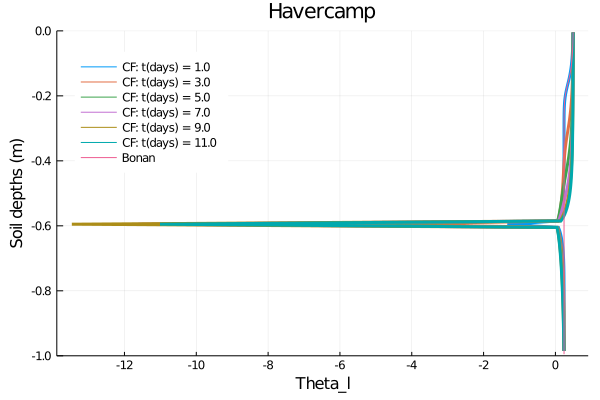

In [23]:
times = collect(86400.0:2*86400.0:11*86400.0)
plt = plot()
for time in times
    plot!(plt, sol_undersaturated_Haver(time),z.-dz[1]/2, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("CF: t(days) = ", time/86400.0), lw=3, legend=:topleft, foreground_color_legend = nothing)
    #plot!(plt, sol_undersaturated_pierreHaver(time),z, xlabel="Theta_l", ylabel="Soil depths (m)", label=string("Pierre: t(s) = ", time), lw=3, legend=:bottomright)
end
#
#plot!(plt,ν_CLiMA, z_CLiMA, label="Clima, 86400.0s",lw=1, legend=:bottomright)\
plot!(bonan[:,1],bonan[:,2]/100, label="Bonan")
title!(plt,"Havercamp")
plot(plt, ylims=(-1,0.))